# NTDS Project

Team members: 
* Armand Boschin
* Bojana Ranković
* Quentin Rebjock

As a reminder, this is a reminder of the project proposal:

***Graph:*** Wikipedia hyperlink network

***Problem:*** Does the structure of the graph bears info on the content of the nodes ? We would like to find out if it is possible to detect communities of pages just by looking at the hyperlink connections and match these communities with real-world data such as categories of the pages. Is spectral clustering a viable possibility compared to proven method of community detection.

***Steps of the project:***
* Scraping the Wikipedia hyperlink network. Start from one node and get the pages as far as 2 or 3 hops depending on the number of nodes we get.
* Model the network by a random graph/scale-free network/something else in order to try to retrieve some of its characteristics.
* Apply Louvain algorithm for community detection to get a baseline to compare spectral clustering to.
* Try to apply spectral clustering in order to detect communities of pages.
* Visualize the clusters to match them with real-world categories (using some of the tools from the last guest lecture).

In [1]:
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import operator
import community

from scipy import linalg, cluster, sparse

from utils import explore_page, load_obj, save_obj, get_bag_of_communities

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1) Data Acquisition

We want to acquire a sub-network of the Wikipedia hyperlink network. In such a graph, each node is a Wikipedia page and there is a link between node a and node b is there is a link to page b on page a. This is a directed network but we will make it undirected later on.

The process of the acquisition is the following : 
* Start from an arbitrary root node (prefer and ambiguous page in order to get as many different communities as possible).
* Explore the page to get the intra-wiki links and get first nodes.
* For each first node, explore the intra-wiki links to get the second nodes.
* Eventually look for inner links by exploring the second nodes (no link from a second node to a first node has been added yet).


We use the `Wikipedia` API that allows us to scrap pages and get links and categories for each one. We chose to include in our network only real pages (not the disambiguation ones). Those pages are indeed useful during the scraping because they allow us to get a larger sample of the real graph. Disambiguation pages act like bridges between pages that have nothing to do together.

For each node we need to get URL, title, most important category and links to other pages.

We use as `root_node` the disambiguation page [Jaguar](https://en.wikipedia.org/wiki/Jaguar_(disambiguation) as it lists a really wide variety of themes (animals, cars, music, films, weapons...). The aim is to scrap pages from as many different communities as possible.

In [ ]:
root_node = 'Jaguar (disambiguation)'

network = {}  # This dict stores for each page the list of its neighbors.
first_nodes = []

explore_page(root_node, network, first_nodes)

second_nodes = []
for node in first_nodes:
    explore_page(node, network, second_nodes)

Look for connections between second nodes and the rest of the nodes.

In [ ]:
all_nodes = list(network.keys()) + second_nodes
for link in tqdm_notebook(second_nodes):
    explore_page(link, network, [], inner=True, all_nodes=all_nodes)

The above cell took 2 hours and 47 minutes to run (duration of scraping).

Now we need to go through all the second nodes that were added to the dictionnary `Network` in order to remove from their neighbors the disambiguation pages that can have been added.

In [ ]:
all_nodes = list(network.keys())
for title in tqdm_notebook(second_nodes):
    network[title]['links'] = list(set(network[title]['links']).intersection(set(all_nodes)))

In [ ]:
l = list(network.keys())
for i in l:
    if len(network[i]['links']) == 0:
        del network[i]

#### Cleaning the categories

There are some categories for each page that are irrelevant in our work (e.g. "All articles with unsourced statements"). We need to get rid of those.

In [71]:
for i, title in enumerate(network.keys()):
    cats = network[title]['categories']
    new_cats = []
    for c in cats:
        if not c.startswith('Redundant') and not c.startswith('Pages') and not c.startswith('Webarchive') and not c.startswith('Wikipedia') and not c.startswith('Articles') and not c.startswith('Coordinates on Wikidata') and not 'Wikidata' in c and not c.startswith('CS1') and not c.startswith('Living') and not c.startswith('All') and not c.startswith('Good articles') and not c.startswith('Use mdy'):
            new_cats.append(c)
    network[title]['categories'] = new_cats

#### Creating pickle files

As the scraping of the network takes quite some time ($\sim$ 3 hours) (especially getting the inner connections), we store the results in pickle files.

In [177]:
# save_obj(network, 'network')
network = load_obj('network')

### Network creation

Let's convert the collected network into a networkx instance which is quite handy to manipulate.

Let's make it undirected as well.

In [4]:
neighbors = {}
for i in network.keys():
    neighbors[i] = network[i]['links']

In [5]:
g = nx.Graph(neighbors)

# 2) Data Exploration

In this part of the notebook, we provide some indicators of the data in order to understand what we'll be working on.

TODO: properties of the collected network

* Adjacency matrix
* Degrees distribution
* Average degree
* Diameter of the collected network
* (Pruning the collected network if necessary ?)
* Visualization of the network

In [6]:
print('Total number of nodes : {}'.format(len(g.nodes)))
print('Total number of edges : {}'.format(len(g.edges)))
if nx.is_connected(g):
    print('The graph is connected.')
else:
    print('The graph is not connected.')

Total number of nodes : 6830
Total number of edges : 367274
The graph is connected.


#### Adjacency Matrix

In [7]:
adj = nx.adjacency_matrix(g)

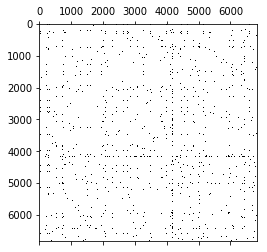

In [8]:
plt.spy(adj.todense())

Check if it's symmetric :

In [9]:
(adj != adj.T).count_nonzero() == 0

True

#### Degrees distribution

As there are some clear outliers making the visualization difficult, we can truncate the degrees or just use a box plot.

In [10]:
degrees = np.array(adj.sum(axis=1)).squeeze()
degrees_truncated = degrees[degrees < 700]

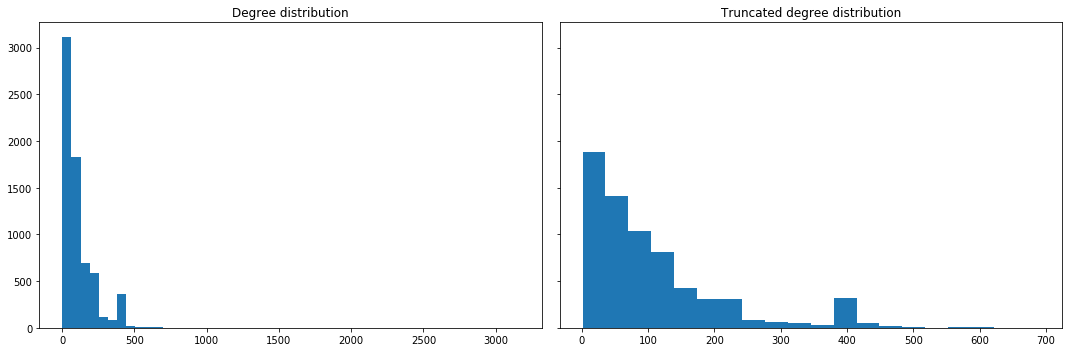

In [11]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

ax[0].set_title('Degree distribution')
#sns.distplot(degrees, bins=50, ax=ax[0, 0])
ax[0].hist(degrees, bins=50)

ax[1].set_title('Truncated degree distribution')
#sns.distplot(degrees_truncated, bins=20, ax=ax[0, 1])
ax[1].hist(degrees_truncated, bins=20)

plt.tight_layout()
plt.show()

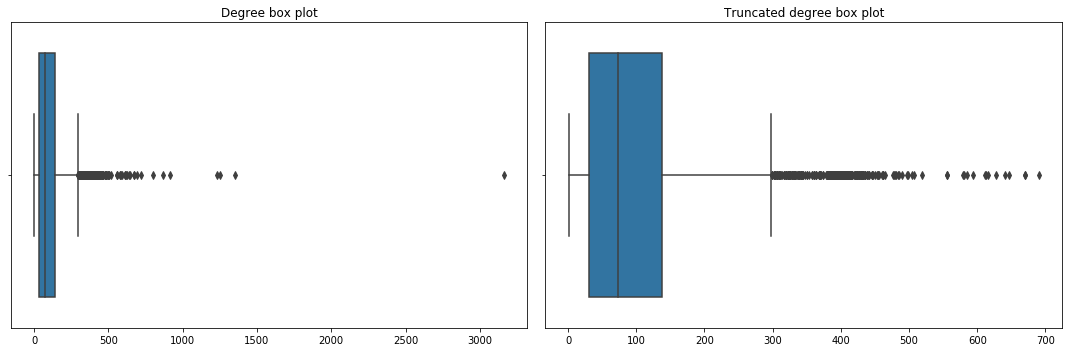

In [12]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

ax[0].set_title('Degree box plot')
sns.boxplot(degrees, ax=ax[0])

ax[1].set_title('Truncated degree box plot')
sns.boxplot(degrees_truncated, ax=ax[1])

plt.tight_layout()
plt.show()

#### Average degree

In [13]:
avg_degree = np.mean(degrees)
print('The average degree of the network is {}.'.format(np.round(avg_degree, 2)))

The average degree of the network is 107.55.


#### Diameter

First we compute the shortest paths lengths. NetworkX allows us to do the computation and returns a dictionnary. This will be useful later on.

In [14]:
# p = dict(nx.shortest_path_length(g))
# save_obj(p, 'shortest_paths')

As this computation is quite long ($\sim$ 3 hours), we dumped the resulting dictionnary in a pickle file.

In [15]:
p = load_obj('shortest_paths')

Now the computation of the diameter results in finding the largest distance in the above dictionnary. Let's turn the dictionnary into a numpy array that is faster to manipulate.

In [16]:
nodes = list(network.keys())

In [17]:
distances = np.zeros(shape=(len(nodes), len(nodes)))
for i in range(len(nodes)):
    for j in range(len(nodes)):
        distances[i, j] = p[nodes[i]][nodes[j]]

NB: The above computation cannot be vectorized are we are getting data from a dictionnary.

In [18]:
diameter = np.amax(distances)
print('The diameter of the network is {}.'.format(int(diameter)))

The diameter of the network is 5.


At first sight, if we had scraped first nodes and then second nodes, we should have had a diameter less than 4. Because a node should be at distance at most 2 from the root node.

Here, thanks to the use of disambiguation pages, we manage to get nodes that are further away from the root node but surprisingly our graph is connected anyway.

#### Visualization

In [ ]:
nx.draw(g, node_size=5)

# 3) Data Exploitation

## 3.1) Modelisation of the network

In this section, we are trying to model the collected network with a simpler one, trying to get the same principal features like the number of nodes, the number of edges, the degree distribution, the shape of the giant components, and so on. Such a model is particularly useful to understand the original network by working on a less complex structure.

### Exploration of the degree distribution

Let's first explore the original network distribution to see what kind of networks could fit. Here are two helper functions that will help later :

In [11]:
"""
Plot the degree distribution of a given networkx graph.
"""
def plot_degree_distr(graph, figsize=(15, 6), title='Degree distribution'):
    fig, ax = plt.subplots(figsize=figsize)
    
    d = list(dict(graph.degree()).values())
    sns.distplot(list(d), bins = 16, ax=ax);
    ax.set_ylabel('Number of vertices')
    ax.set_xlabel('Degree')
    ax.set_title(title)
    plt.show()

"""
Returns the degree distribution of a given networkx graph. The returned
value is an array whose k'th entry is the probability of a node to have
the degree k.
"""
def get_distribution(a):
    if type(a) == nx.classes.graph.Graph:
        probabilities = np.zeros(len(a) + 1)
        for k in nx.adjacency_matrix(a).sum(axis=1):
            probabilities[k] += 1
        probabilities = probabilities/np.sum(probabilities)
    return probabilities

In [12]:
nNodes = len(g.nodes())
nEdges = g.size()

min_degree = np.min(degrees)
max_degree = np.max(degrees)

print('The network has {0} nodes and {1} edges.'.format(nNodes, nEdges))

print('The minimum and the maximym degrees are respectively {0} and {1}.'.format(min_degree, max_degree))

The network has 6830 nodes and 367483 edges.
The minimum and the maximym degrees are respectively 1 and 3162.


**Let's plot the degree distribution of the collected network**

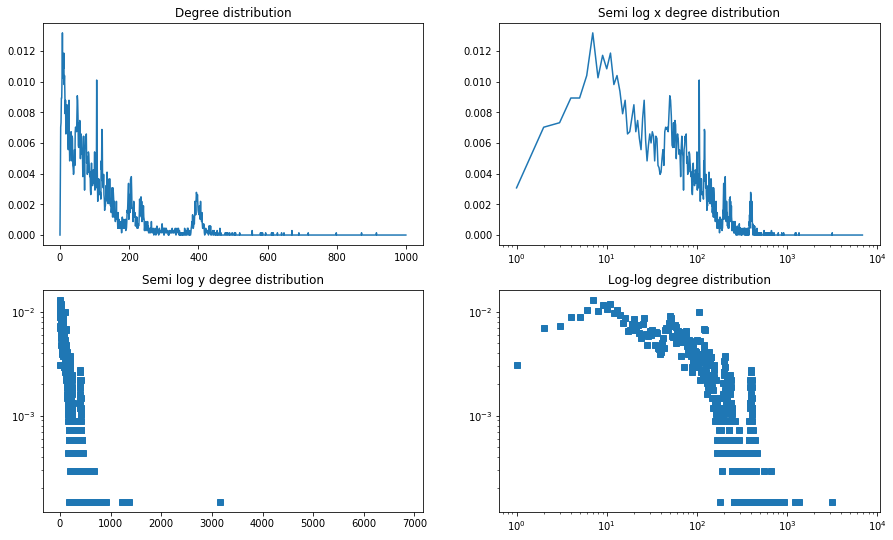

In [13]:
probability_distribution = get_distribution(g)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

ax[0, 0].set_title('Degree distribution')
ax[0, 0].plot(probability_distribution[:1000])

ax[0, 1].set_title('Semi log x degree distribution')
ax[0, 1].semilogx(probability_distribution)

ax[1, 0].set_title('Semi log y degree distribution')
ax[1, 0].semilogy(probability_distribution, 's')

ax[1, 1].set_title('Log-log degree distribution')
ax[1, 1].loglog(probability_distribution, 's')

The previous plots show that the degree distribution of the network is complicated and doesn't fit exactly any of the basic network structures studied during the semester. However the last log-log plot suggests that a scale-free network with a power law could approximate the distribution. Let's make a regression to see what coefficient would fit.

The best linear approximation is y = [[-1.06933683]]x + [-1.40567422].


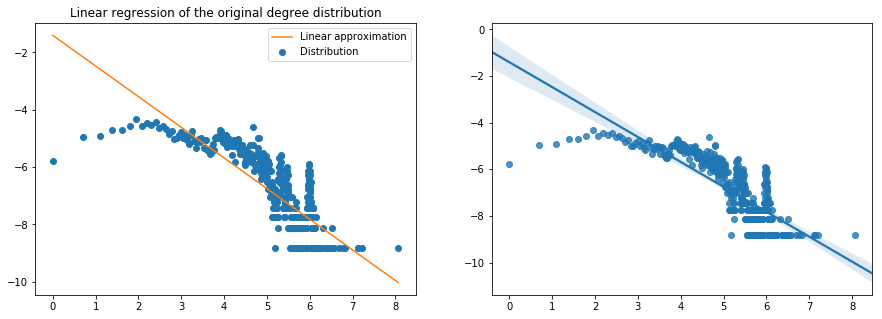

In [14]:
from sklearn import linear_model

x = np.where(probability_distribution != 0)[0]
y = probability_distribution[x]

logx = np.log(x).reshape(-1, 1)
logy = np.log(y).reshape(-1, 1)

regr_ogirinal = linear_model.LinearRegression()
regr_ogirinal.fit(logx, logy)

print('The best linear approximation is y = {0}x + {1}.'.format(regr_ogirinal.coef_, regr_ogirinal.intercept_))

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].scatter(logx, logy, color='C0', label='Distribution')
ax[0].plot(logx, regr_ogirinal.coef_*logx + regr_ogirinal.intercept_, color='C1', label='Linear approximation')
ax[0].set_title('Linear regression of the original degree distribution')
ax[0].legend(loc='upper right')

sns.regplot(logx, logy[:, 0], ax=ax[1]);

We will later use that regression to build an approximation of the network.

### Modelisation with basic network structures

#### Erdős–Rényi graph

The Erdős–Rényi graph models a random network where each pair of nodes has a fixed probability to be linked. We want this network to have the same number of nodes as the original one, and approximate the number of edges as much as possible.

In [15]:
p = 2*nEdges/nNodes/(nNodes - 1)

print('The probability hyper-parameter giving the best approximation of the number of edges is {}'.format(np.round(p, 4)))

The probability hyper-parameter giving the best approximation of the number of edges is 0.0158


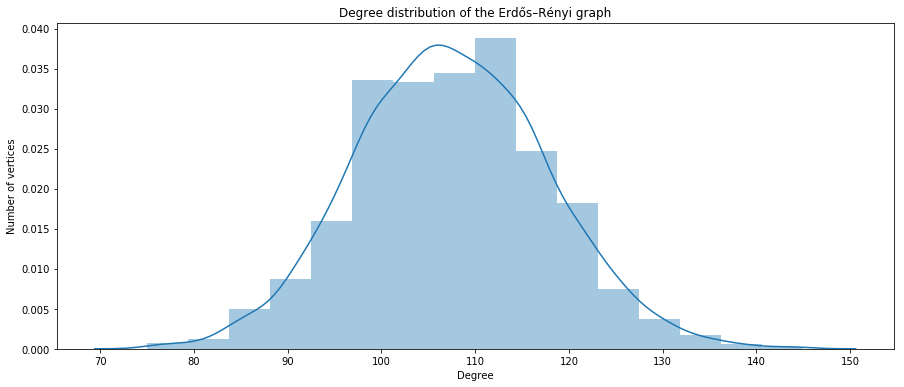

In [16]:
er = nx.erdos_renyi_graph(nNodes, p)

plot_degree_distr(er, title='Degree distribution of the Erdős–Rényi graph')

As expected, it clearly doesn't match the distribution of our network. The random networks have a Poisson degree distribution (when the number of nodes is large) and it doesn't fit to the observed distribution.

#### Barabási-Albert

The Barabási-Albert graph follows a power law distribution (in theory $p(k) = C*k^{-3}$) so we can hope much better results than with the random network modeling. The number of nodes that we want in the graph is fixed and we can only play with the parameter specifying the number of edges to attach from a new node to existing nodes. With the trial and error method, we found out that setting this parameter to 54 gives the closest number of edges to our original graph.

This Barabási-Albert network has 365904 edges while our original network has 367483 edges.


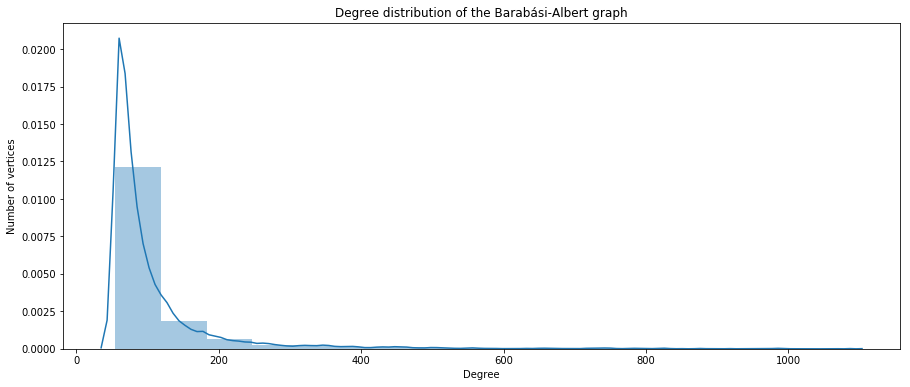

In [74]:
ba = nx.barabasi_albert_graph(nNodes, 54)

print('This Barabási-Albert network has {0} edges while our original network has {1} edges.'.format(ba.size(), nEdges))

plot_degree_distr(ba, title='Degree distribution of the Barabási-Albert graph')

It indeed seems to be a power law distribution. Let's have a deeper insight and try to measure the parameter of this power law (it should be 3 in theory).

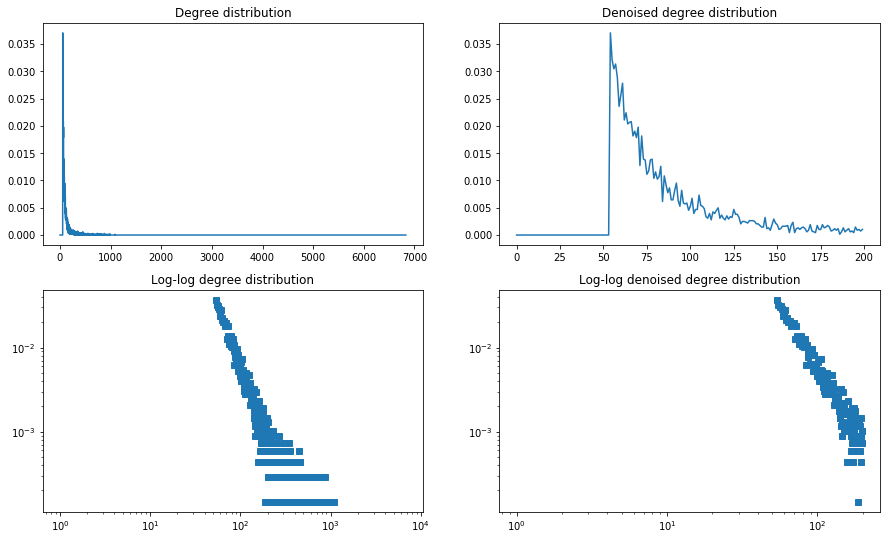

In [75]:
probability_distribution = get_distribution(ba)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

ax[0, 0].set_title('Degree distribution')
ax[0, 0].plot(probability_distribution)

ax[0, 1].set_title('Denoised degree distribution')
ax[0, 1].plot(probability_distribution[:200])

ax[1, 0].set_title('Log-log degree distribution')
ax[1, 0].loglog(probability_distribution, 's')

ax[1, 1].set_title('Log-log denoised degree distribution')
ax[1, 1].loglog(probability_distribution[:200], 's')

**Regression to measure the law's coefficient**

The best linear approximation is y = [[-2.77729036]]x + [ 7.54534962].


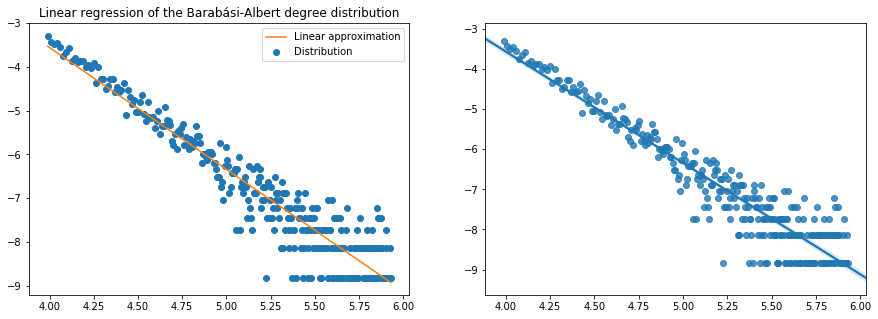

In [76]:
x = np.where(probability_distribution != 0)[0]
y = probability_distribution[x]

logx = np.log(x)
logy = np.log(y)

logx = logx[:300]
logy = logy[:300]

logx = logx.reshape(-1, 1)
logy = logy.reshape(-1, 1)

regr_ba = linear_model.LinearRegression()

regr_ba.fit(logx, logy)

print('The best linear approximation is y = {0}x + {1}.'.format(regr_ba.coef_, regr_ba.intercept_))

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].scatter(logx, logy, color='C0', label='Distribution')
ax[0].plot(logx, regr_ba.coef_*logx + regr_ba.intercept_, color='C1', label='Linear approximation')
ax[0].set_title('Linear regression of the Barabási-Albert degree distribution')
ax[0].legend(loc='upper right')

sns.regplot(logx, logy[:, 0], ax=ax[1]);

We get a coefficient close to 3 which is the expected value. Thus this network will be a better approximation than the random network precedently exposed but is still not ideal : we would like a power law network whose coefficient is closer to 1.0693 as computed earlier.

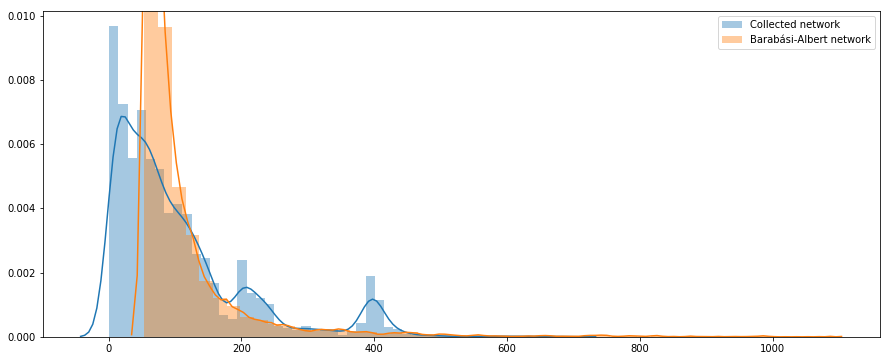

In [77]:
ba_degrees = list(dict(ba.degree()).values())

f, ax = plt.subplots(figsize=(15, 6))

sns.distplot(degrees_truncated, label='Collected network', ax=ax)
sns.distplot(ba_degrees, label='Barabási-Albert network', ax=ax)

plt.legend(loc='upper right')
plt.show()

We clearly see here that it is a better approximation but is still not ideal.

#### A power law network with the right exponent

In this section we are trying to make a power law network with a closer exponent to the one measured in the regression of the original network. We didn't find any method to make a graph with the exact exponent but we approximated it with the following code. The configuration_model from networkx allows us to create a graph from a given list of degrees.

In [78]:
while True:  
    s = []
    while len(s) < nNodes:
        nextval = int(nx.utils.powerlaw_sequence(1, 1.8)[0])
        if nextval != 0:
            s.append(nextval)
    if sum(s) % 2 == 0:
        break

power_law = nx.configuration_model(s)
power_law = nx.Graph(power_law) # remove parallel edges
power_law.remove_edges_from(power_law.selfloop_edges())

print('This power law network has {0} nodes and {1} edges.'.format(len(power_law), power_law.size()))

This power law network has 6830 nodes and 30175 edges.


We can check that it indeed follows a power law distribution :

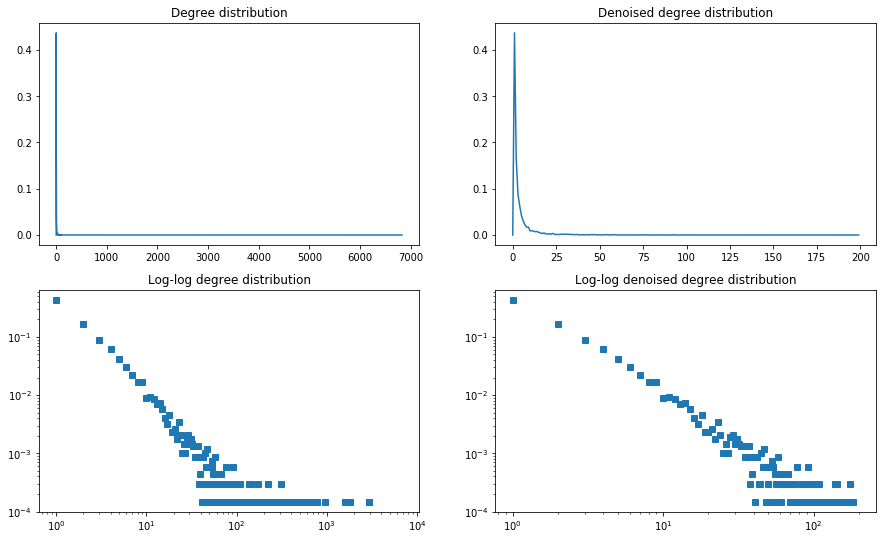

In [79]:
probability_distribution = get_distribution(power_law)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

ax[0, 0].set_title('Degree distribution')
ax[0, 0].plot(probability_distribution)

ax[0, 1].set_title('Denoised degree distribution')
ax[0, 1].plot(probability_distribution[:200])

ax[1, 0].set_title('Log-log degree distribution')
ax[1, 0].loglog(probability_distribution, 's')

ax[1, 1].set_title('Log-log denoised degree distribution')
ax[1, 1].loglog(probability_distribution[:200], 's')

And we calculate here the coefficient of the power law :

The best linear approximation is y = [[-1.88266739]]x + [-0.29357478].


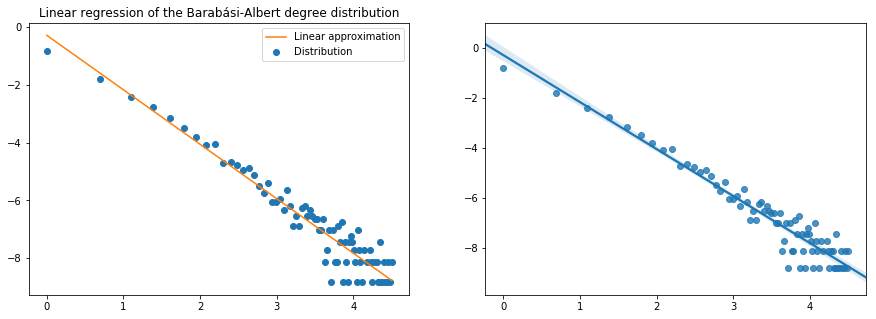

In [80]:
x = np.where(probability_distribution != 0)[0]
y = probability_distribution[x]

logx = np.log(x)
logy = np.log(y)

logx = logx[:79]
logy = logy[:79]

logx = logx.reshape(-1, 1)
logy = logy.reshape(-1, 1)

regr_power_law = linear_model.LinearRegression()

regr_power_law.fit(logx, logy)

print('The best linear approximation is y = {0}x + {1}.'.format(regr_power_law.coef_, regr_power_law.intercept_))

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].scatter(logx, logy, color='C0', label='Distribution')
ax[0].plot(logx, regr_power_law.coef_*logx + regr_power_law.intercept_, color='C1', label='Linear approximation')
ax[0].set_title('Linear regression of the Barabási-Albert degree distribution')
ax[0].legend(loc='upper right')

sns.regplot(logx, logy[:, 0], ax=ax[1]);

It's indeed closer to the original network but there is still a little gap. However the number of edges of this power law network is extremely low compared to the original network. It seems like the Barabási-Albert network is a better approximation even if the distribution is worse.

### Giant components and Clustering coefficient

#### Giant components

In this part we are analyzing the giant components of the original network and of the approximations created.

In [81]:
giant_g = max(nx.connected_component_subgraphs(g), key=len)
giant_er = max(nx.connected_component_subgraphs(er), key=len)
giant_ba = max(nx.connected_component_subgraphs(ba), key=len)
giant_pl = max(nx.connected_component_subgraphs(power_law), key=len)

In [82]:
print('The size of the giant components of the original, the Erdős–Rényi, the Barabási-Albert and the power law '
      'networks are respectively {0}, {1}, {2} and {3}'.format(len(giant_g.nodes()), len(giant_er.nodes()),
                                                          len(giant_ba.nodes()), len(giant_pl.nodes())))

The size of the giant components of the original, the Erdős–Rényi, the Barabási-Albert and the power law networks are respectively 6830, 6830, 6830 and 6806


The original network, the Erdős–Rényi and the Barabási-Albert graphs are fully connected so their giant components are the whole graphs. The modelisation with the last power law network has also a very big giant component and is almost fully connected. Finally these models respect this feature of our original network.

#### Clustering coefficient

The average clustering coefficient measures the overall degree of clustering in the network. Real-world networks tend to have a higher average clustering coefficient because of their aptitude to have compact groupements of nodes so we expect it to be greater than the models.

In [83]:
avg_clustering_g = nx.average_clustering(g)
avg_clustering_er = nx.average_clustering(er)
avg_clustering_ba = nx.average_clustering(ba)
avg_clustering_pl = nx.average_clustering(power_law)

print('The average clustering coefficients of the original, the Erdős–Rényi, the Barabási-Albert and the power law '
      'networks are respectively {0}, {1}, {2} and {3}'.format(np.round(avg_clustering_g, 3),
                                                               np.round(avg_clustering_er, 3),
                                                               np.round(avg_clustering_ba, 3),
                                                               np.round(avg_clustering_pl, 3)))

The average clustering coefficients of the original, the Erdős–Rényi, the Barabási-Albert and the power law networks are respectively 0.643, 0.016, 0.048 and 0.451


The last model created following a power law has the closest clustering coefficient. But we also showed that this network sorely lacks of edges to be a good model.

### Comparison with common networks from the web

Most scale-free networks follow a distribution of the form $p(k) = C*k^{-\gamma}$ where $2 < \gamma < 3$ usually. In the approximation by a power law distribution we made, we found out that $\gamma \simeq 1.0693$ which is a value common at all as the following table presenting some values of gamma shows.


| Network              | Gamma |
|----------------------|-------|
| WWW in               | 2.00  |
| WWW out              | 2.31  |
| Emails in            | 3.43  |
| Emails out           | 2.03  |
| Actor                | 2.12  |
| Protein interactions | 2.12  |
| Citations in         | 3.03  |
| Citations out        | 4.00  |

First we may wonder why a scale free network seems to be a good approximation of the collected network. One of the most notable caracteristic of a scale free network is the presence of nodes with a degree much larger than the average which is the case here :

In [52]:
print('The average degree is {0}, and there are {1} nodes whose degrees are 5 times higher than the average '
      'and {2} nodes whose degrees are 10 times higher.'.format(np.round(np.mean(degrees), 1),
                                                                np.count_nonzero(degrees > 5*np.mean(degrees)),
                                                                np.count_nonzero(degrees > 10*np.mean(degrees))))

The average degree is 107.5, and there are 23 nodes whose degrees are 5 times higher than the average and 4 nodes whose degrees are 10 times higher.


It's in fact quite intuitive when you know that the network is composed of nodes representing wikipedia webpages and being linked if there is a link directing from one of the page to the other one. We expect a few large hubs (wikipedia webpages covering an important subject) appearing in such a network, followed by smaller ones (moderately important subjects) in a larger proportion and finally quite a lot of unimportant ones. The plots above show that the distribution respects that trend pretty much, except that there are fewer unimportant and very important topics that in a real scale free network.

The preferential attachment process is another intuitive way to understand why the scrapped network looks like a scale free network. This process is also known as "the rich get richer and the poor get poorer" : a quantity (here the links between the nodes) is distributed according to how much they already have. It has been shown that such a process produces scale free networks and most algorithms (like the Barabási-Albert one) use this principle to create such networks. Regarding wikipedia, the more popular a page is and the more the topic is important, the more links it will have and conversely for lesser known pages. It is exactly a preferential attachment phenomena.

## 3.2) Community detection using Spectral clustering



We will try to use the collected data to answer our problem which is: 
 **Can we isolate communities of pages just by looking at the hyperlink graph ? **
 
This is the famous community detection problem for which a popular method is the [Louvain Algorithm](https://en.wikipedia.org/wiki/Louvain_Modularity).
 
The measure of performance we will use for the community detection is the modularity. Modularity measures the strengh of the division of a network into sub-groups. A network with high modularity has dense intra-connections (within sub-groups) and sparse inter-connections (between different groups).

Louvain as been presented in 2008 and though it has been improved [[1](https://link.springer.com/chapter/10.1007/978-3-319-11683-9_12)], we will use this as a baseline to compare the performance of spectral clustering for community detection.

The steps are the following :
 * Louvain algorithm as a baseline
 * Spectral clustering
 * Visualization of the communities

### 3.2.1) Louvain community detection

We use the Python library [`community`](https://pypi.python.org/pypi/python-louvain/0.3) that implements the Louvain algorithm.

This library also allows us to compute the modularity of a given partition of the nodes.

In [19]:
louvain_partition = community.best_partition(g)

In [20]:
louvain_modularity = community.modularity(louvain_partition, g)
louvain_modularity

0.7878265124723326

In [25]:
k_louvain = len(set(louvain_partition.values()))
print('Louvain algorithm found {} communities'.format(k_louvain))

Louvain algorithm found 16 communities


We can try to visualize the categories of the nodes in each of these communities. From the scraping, we got for each page a list of categories in which the page belongs. Let's compute for each community what we'll call a bag of categories that is the list of all the categories of the nodes it contains and the count of the number of nodes that belong to this category for each one.

The function can be found in `utils.py`, it's implementation is quite straight-forward.

In [72]:
louvain_bag = get_bag_of_communities(network, louvain_partition)

Let's get the number of pages in each community.

In [111]:
louvain_counts = [0 for _ in range(k_louvain)]
for i, title in enumerate(louvain_partition.keys()):
    louvain_counts[louvain_partition[title]] += 1

Now we want to visualize the categories of the nodes in each community. We print for each community the 10 most represented categories of the community.

In [112]:
for i in range(k_louvain):
    sorted_bag = sorted(louvain_bag[i].items(), key=operator.itemgetter(1), reverse=True)
    print(' ')
    print('Community {}/{} ({} pages) : '.format(i+1, k_louvain, louvain_counts[i]))
    for ind in range(10):
        print(sorted_bag[ind])

 
Community 1/16 (1120 pages) : 
('Single-engined tractor aircraft', 102)
('Carrier-based aircraft', 92)
('Biplanes', 66)
('Low-wing aircraft', 65)
('Single-engined jet aircraft', 57)
('High-wing aircraft', 53)
('Twinjets', 48)
('Mid-wing aircraft', 45)
('Grumman aircraft', 44)
('Breguet aircraft', 44)
 
Community 2/16 (549 pages) : 
('Jaguar vehicles', 44)
('Ford Motor Company', 43)
('Rear-wheel-drive vehicles', 40)
('Motor vehicle manufacturers of the United Kingdom', 36)
('Defunct motor vehicle manufacturers of England', 33)
('Car manufacturers of the United Kingdom', 30)
('Car brands', 29)
('Sports car manufacturers', 29)
('Defunct motor vehicle manufacturers of the United Kingdom', 28)
('Former defence companies of the United Kingdom', 28)
 
Community 3/16 (331 pages) : 
('Liga MX seasons', 73)
('Liga MX teams', 18)
('Member states of the United Nations', 17)
('Spanish-speaking countries and territories', 16)
('Liga MX players', 15)
('Former Spanish colonies', 15)
('Chiapas F.C. m

We can see that we get some nice results because it seems that a general topic can be infered for each community. The topics are: 

|Louvain Order|Alphabetical Order|
|---|---|
|Aircrafts| Aircrafts|
|Cars|American Footbal|
|Spanish related topics| Animals / mammals |
|American Footbal| Apple inc. |
|Apple inc.| British ships |
|British ships| Cars |
|Formula One car races| Comics and fictional characters |
|Songwriters| Electronics |
|Weapons| Formula One car races |
|Animals / mammals| Luxury in Britain |
|Rugby| Music instruments |
|Luxury in Britain| Rugby |
|Comics and fictional characters| Social science |
|Music instruments| Songwriters |
|Electronics| Spanish related topics |
|Social science | Weapons |

### 3.2.2) Spectral Clustering

Nows let's try a spectral clustering approach for this community detection problem.

#### 3.2.2.1 Using the natural graph

The first idea is to use the natural graph, that is each node is a page and there is an edge of weight 1 between two pages if one of the pages links to the other.

We define the graph laplacian using the formula $L = D- A$ where $D$ is the diagonal matrix containing the degrees and $A$ is the adjacency matrix.

In [156]:
laplacian = np.diag(degrees) - adj.todense()
laplacian = sparse.csr_matrix(laplacian)

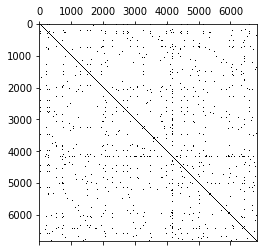

In [157]:
plt.spy(laplacian.todense())

In order to do spectral clustering using this Laplacian, we need to compute the $k$ first eigenvalues and corresponding eigenvectors. We get a matrix $U$ of $\mathbb{R}^{n \times k}$ where $n$ is the number of nodes in the graph. Applying a k-means algorithm in order to clusterize the $n$ vectors of $\mathbb{R}^k$ corresponding to the lines of $U$ gives us a clustering of the $n$ nodes.

Here we need to specify the number of clusters (communities) we want to look for. Let's use the same number as the number of cummunities Louvain algo returned.

In [158]:
k_spectral = k_louvain + 5

In [159]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian.asfptype(), k=k_spectral, which='SM')

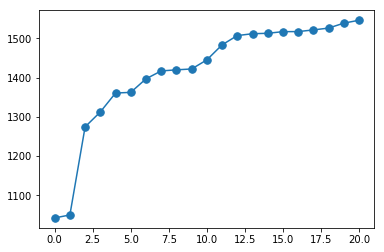

In [160]:
plt.plot(eigenvalues, '.-', markersize=15)

In [178]:
eigenvalues[:2]

array([-5.70463813e-14,  8.67614857e-01])

We check that the first eigenvalue is 0 but the second is not. The graph is connected.

Now we clusterize the resulting vectors in $\mathbb{R}^k$

In [161]:
centroids, labels = cluster.vq.kmeans2(eigenvectors, k_spectral)

/usr/local/lib/python3.5/dist-packages/scipy/cluster/vq.py:523: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In order to get a first idea of how this algorithm did, let's look at the number of nodes in each cluster.

In [162]:
cc = [0 for i in range(40)]
for i in labels:
    cc[i] += 1
', '.join([str(i) for i in cc])

'68, 1, 0, 1, 0, 2, 2, 1, 0, 3, 2, 1, 1, 2, 1, 6741, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0'

We can see that with almost all the clusters containing less than 3 nodes, this first algorithm did not perform really well.

### 3.2.2.2 Building another graph

As we have seen in class and in one of the homework. In order for spectral clustering to work, we need to assign edge weights that are stronger the closer the nodes are.

Let's build another graph with still the same vertex but some new edges between them.

We have already computed the distances in the graph let's define edges with weights using a kernel (e.g. the Gaussian kernel).

In [163]:
kernel_width = distances.mean()
weights = np.exp(-np.square(distances)/kernel_width**2)

np.fill_diagonal(weights, 0)

This creates a complete graph. We could sparsify it for faster computations but this is not really long and experience seems to show that results are better with the full graph.

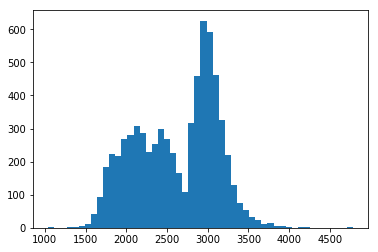

In [164]:
degrees = np.sum(weights, axis=0)

plt.hist(degrees, bins=50);

In [165]:
laplacian = np.diag(1/np.sqrt(degrees)).dot((np.diag(degrees) - weights).dot(np.diag(1/np.sqrt(degrees))))

We can check that the obtained Laplacian matrix is symmetric.

In [166]:
tol = 1e-8
np.allclose(laplacian, laplacian.T, atol=tol)

True

In [167]:
eigenvalues, eigenvectors = linalg.eigh(laplacian, eigvals=(0, k_spectral-1))

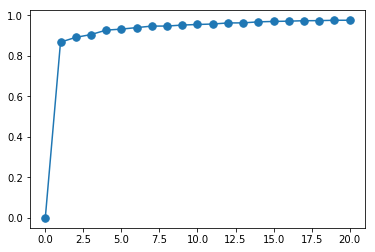

In [168]:
plt.plot(eigenvalues, '.-', markersize=15)

In [169]:
centroids, labels = cluster.vq.kmeans2(eigenvectors, k_spectral)

In [170]:
cc = [0 for i in range(k_spectral)]
for i in labels:
    cc[i] += 1
', '.join([str(i) for i in cc])

'397, 475, 425, 983, 81, 310, 482, 164, 331, 480, 203, 359, 364, 296, 322, 158, 141, 154, 275, 297, 133'

This seems better. We get pages distributed among all the clusters (with somme clusters more important than the others of course.

First let's have a look at the categories of each cluster.

In [171]:
spectral_partition = {}
for i, title in enumerate(network.keys()):
    spectral_partition[title] = labels[i]

In [172]:
spectral_bag = get_bag_of_communities(network, spectral_partition)

In [173]:
spectral_counts = [0 for _ in range(k_spectral)]
for i, title in enumerate(spectral_partition.keys()):
    spectral_counts[spectral_partition[title]] += 1

In [174]:
for i in range(k_spectral):
    sorted_bag = sorted(spectral_bag[i].items(), key=operator.itemgetter(1), reverse=True)
    print(' ')
    print('Community {}/{} ({} pages) : '.format(i+1, k_spectral, spectral_counts[i]))
    for ind in range(10):
        print(sorted_bag[ind])

 
Community 1/21 (397 pages) : 
('Empire ships', 64)
('Ship infoboxes without an image', 62)
('Ministry of War Transport ships', 61)
('Steamships of the United Kingdom', 59)
('Use dmy dates from January 2017', 34)
('Merchant ships of the United Kingdom', 31)
('Use British English from January 2017', 27)
('Single-engined tractor aircraft', 27)
('Use dmy dates from December 2016', 25)
('Clyde-built ships', 24)
 
Community 2/21 (475 pages) : 
('IUCN Red List least concern species', 166)
('Carnivora stubs', 56)
('IUCN Red List vulnerable species', 42)
('Mammals of the United States', 36)
('Mammal genera', 36)
('Carnivorans of Africa', 35)
('Carnivorans of Malaysia', 34)
('Mammals of Asia', 34)
('Mammals described in 1758', 33)
('Mammals of India', 32)
 
Community 3/21 (425 pages) : 
('Jacksonville Jaguars players', 115)
('Jacksonville Jaguars currentteam parameter articles', 85)
('Infobox NFL biography articles missing alt text', 64)
('NFL player missing current team parameter', 44)
('NFL 

It seems that we get the same results. As we asked for more communities than Louvain, some of them are split. For example `Electronics` in the Louvain case gets `Video Game Consoles` and `Micro technique devices`. It's a finer division.

In [175]:
spectral_modularity = community.modularity(spectral_partition, g)

In [176]:
spectral_modularity

0.6496636374651106

Modularity is less than the Louvain modularity. 

What could be the advantages of the spectral approach ? 
 - Computation cost ?
 - Measure of the feat of the community detection for the categories (broader problem involving NLP and topic detection).
 
TODO:
- Try other kernels
- Try to sparsify

### 3.2.3 Visualization

In [ ]:
community2color = {
    0: sns.xkcd_rgb["peach"],
    1: sns.xkcd_rgb["powder blue"],
    2: sns.xkcd_rgb["light pink"],
    3: sns.xkcd_rgb["chocolate"],
    4: sns.xkcd_rgb["orange"],
    5: sns.xkcd_rgb["magenta"],
    6: sns.xkcd_rgb["purple"],
    7: sns.xkcd_rgb["blue"],
    8: sns.xkcd_rgb["deep blue"],
    9: sns.xkcd_rgb["sky blue"],
    10: sns.xkcd_rgb["olive"],
    11: sns.xkcd_rgb["seafoam green"],
    12: sns.xkcd_rgb["tan"],
    13: sns.xkcd_rgb["mauve"],
    14: sns.xkcd_rgb["hot pink"],
    15: sns.xkcd_rgb["pale green"],
    16: sns.xkcd_rgb["indigo"],
    17: sns.xkcd_rgb["lavender"],
    18: sns.xkcd_rgb["eggplant"],
    19: sns.xkcd_rgb["brick"],
}

In [ ]:
position = nx.spring_layout(g)

for comunity in set(louvain_partition.values()) :
    list_nodes = [nodes for nodes in louvain_partition.keys()
                                if partition[nodes] == comunity]
    nx.draw_networkx_nodes(G, position, list_nodes, node_size = 20,
                                node_color = community2color[comunity])


nx.draw_networkx_edges(G, position, alpha=0.5)
plt.show()


In [ ]:
nx.set_node_attributes(G, partition, 'community')
nx.set_node_attributes(G, node2category, 'category')


In [ ]:
nx.write_gml(G, "data/full_graph.gml")


In [ ]:
G = nx.read_gml("data/full_graph.gml")

In [ ]:
from IPython.display import Image, display


In [ ]:
Communities by Louvain.

In [ ]:
display(Image(filename='data/louvain.png', embed=True))

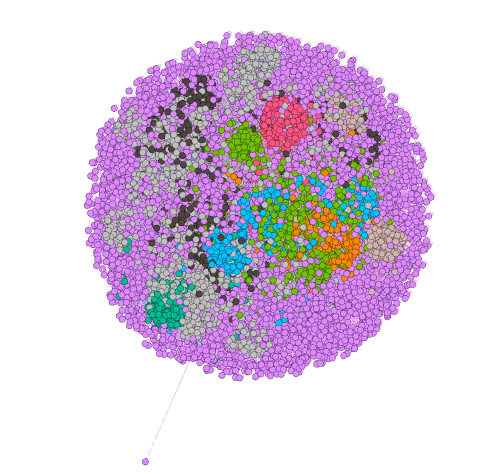

Communities by category


In [ ]:
display(Image(filename='data/communities by category.png', embed=True))

# 5) Conclusion

Improvement for the study :

- We used the measure of modularity as a performance of our algorithm. Need to find a measure of how the communities fit with the various categories. However need to work harder on categories of pages as the data we get from wikipidia is not really clean (NLP task on the categories, topic detection). 